In [117]:
import pandas as pd
import numpy as np
import networkx as nx
import warnings
import dowhy
from dowhy import CausalModel
from dowhy.causal_identifier import backdoor
from IPython.display import Image, display

warnings.filterwarnings("ignore", category=FutureWarning)

data = pd.read_csv("lalonde_data.csv")

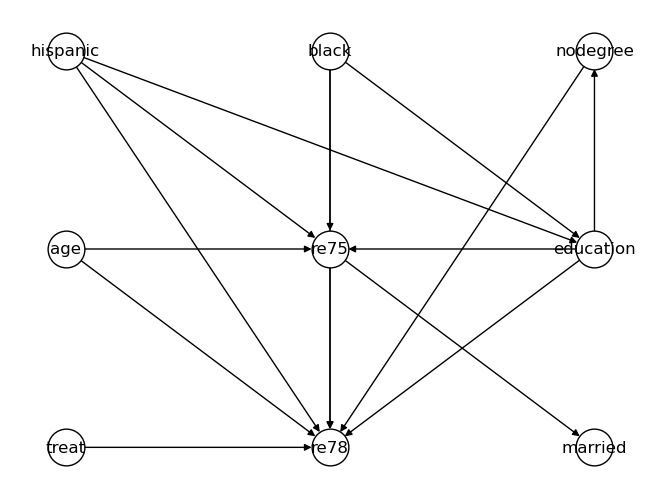

In [118]:
graph_v0 = nx.DiGraph()

var_names = ['treat',
 'age',
 'education',
 'black',
 'hispanic',
 'married',
 'nodegree',
 're75',
 're78']

graph_v0.add_nodes_from(var_names)

graph_v0.add_edges_from([(var_names[0], var_names[8]), (var_names[1], var_names[7]), (var_names[1], var_names[8]), 
                  (var_names[2], var_names[7]), (var_names[2], var_names[8]), (var_names[2], var_names[6]), (var_names[6], var_names[8]),
                  (var_names[7], var_names[5]), (var_names[7], var_names[8]), (var_names[3], var_names[2]), (var_names[4], var_names[2]),
                  (var_names[3], var_names[7]), (var_names[4], var_names[7]), (var_names[3], var_names[8]), (var_names[4], var_names[8])])


coordinates = [(-1,-1), (-1, 0), (1, 0), (0, 1), (-1, 1), (1, -1), (1, 1), (0, 0), (0, -1)]
pos= {key: val for key, val in zip(var_names, coordinates)}

nx.draw(graph_v0, pos= pos, with_labels=True, node_size=700, node_color='w', edgecolors ='black')
nx.write_gml(graph_v0, "backdoor_criterion_graph.gml")

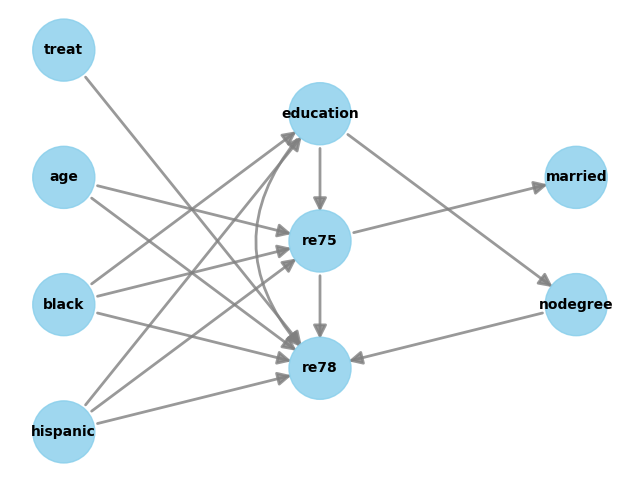

In [119]:
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

gml_graph = gml_to_string('backdoor_criterion_graph.gml')
# With GML string

model=CausalModel(
    data = data,
    treatment='treat',
    outcome='re78',
    graph=gml_graph
)
model.view_model() 

In [120]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d             
────────(E[re₇₈])
d[treat]         
Estimand assumption 1, Unconfoundedness: If U→{treat} and U→re78 then P(re78|treat,,U) = P(re78|treat,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [121]:
identifier = model.identifier
identifier.identify_backdoor(model._graph._graph, model._treatment, model._outcome, list(model._graph.get_all_nodes(include_unobserved=False)))

[{'backdoor_set': set()},
 {'backdoor_set': ('age',
   'black',
   'education',
   'married',
   'hispanic',
   'nodegree',
   're75')},
 {'backdoor_set': ('age',)},
 {'backdoor_set': ('black',)},
 {'backdoor_set': ('education',)},
 {'backdoor_set': ('married',)},
 {'backdoor_set': ('hispanic',)},
 {'backdoor_set': ('nodegree',)},
 {'backdoor_set': ('re75',)}]

In [122]:
# Estimating treatment effect with vaious methods

estimate_linreg = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print("backdoor.linear_regression ATE :", estimate_linreg.value)

backdoor.linear_regression ATE : 828.2248882215099


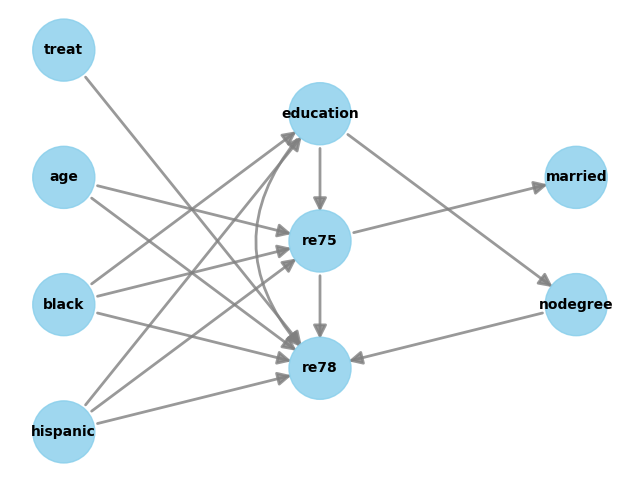

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                        
───────────(E[re78|education])
d[nodegree]                   
Estimand assumption 1, Unconfoundedness: If U→{nodegree} and U→re78 then P(re78|nodegree,education,U) = P(re78|nodegree,education)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

backdoor.propensity_score_matching ATE: -13246.619046759028


ValueError: Not enough data to generate at least two strata. This error may be due to a high value of 'clipping_threshold'.

In [124]:
# make treatment variable binary
data_binary = data.copy()   
# data_binary['education'] = data_binary['education'].apply(lambda x: 1 if x > 12 else 0)
display_data = data_binary.copy()
model=CausalModel(
    data = data_binary,
    treatment='nodegree',
    outcome='re78',
    graph=gml_graph
)
model.view_model()

identified_estimand = model.identify_effect()

print(identified_estimand)

identifier = model.identifier
identifier.identify_backdoor(model._graph._graph, model._treatment, model._outcome, list(model._graph.get_all_nodes(include_unobserved=False)))

estimate_matching = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_matching")
print("backdoor.propensity_score_matching ATE:", estimate_matching.value)

estimate_strat = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_stratification")
print("backdoor.propensity_score_stratification ATE :", estimate_strat.value)

estimate_weight = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_weighting")
print("backdoor.propensity_score_weighting ATE :", estimate_weight.value)




threshold for education: propensity score matching, stratification, weighting
```
5:  -199.53     nan
6:  -272.80     563.94      1435.56
7:  2719.71     672.53      817.39
8:  4604.79     839.63      833.58
9: -1272.04     197.93      206.56
10:  199.84     502.49      512.37
11:-2650.90     1218.71     1246.84
12:-2374.       4654.12     3444.40
...
```

Refute: Add a random common cause
Estimated effect:806.5112894563372
New effect:803.797650008755
p value:0.94

Refute: Use a Placebo Treatment
Estimated effect:806.5112894563372
New effect:2.207343641202897e-09
p value:0.0

Refute: Use a subset of data
Estimated effect:806.5112894563372
New effect:810.1282351746383
p value:1.0



/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


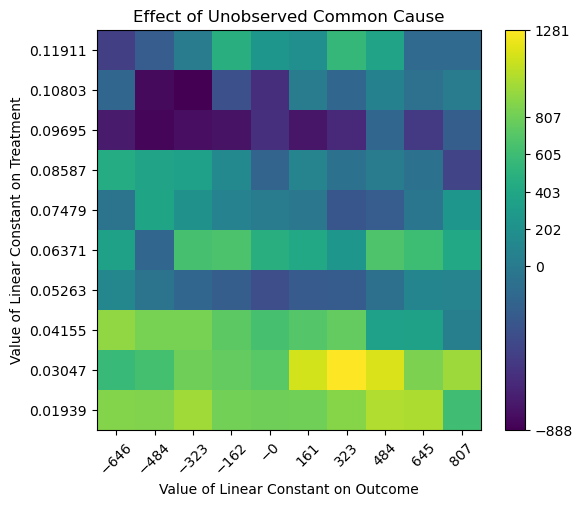

Refute: Add an Unobserved Common Cause
Estimated effect:806.5112894563372
New effect:(-888.4606626765899, 1280.504832311627)



In [113]:
res_random_linreg=model.refute_estimate(identified_estimand, estimate_linreg, method_name="random_common_cause")
print(res_random_linreg)

res_placebo=model.refute_estimate(identified_estimand, estimate_linreg, method_name="placebo_treatment_refuter")
print(res_placebo)

res_subset=model.refute_estimate(identified_estimand, estimate_linreg, method_name="data_subset_refuter")
print(res_subset)

res_add=model.refute_estimate(identified_estimand, estimate_linreg, method_name="add_unobserved_common_cause")
print(res_add)


In [114]:
print(data_binary['treat'].value_counts())
print(data_binary.shape)
print(estimate_matching.estimator.data)



treat
0.0    425
1.0    297
Name: count, dtype: int64
(722, 23)


AttributeError: 'PropensityScoreMatchingEstimator' object has no attribute 'data'

In [30]:
res_random_matching=model.refute_estimate(identified_estimand, estimate_matching, method_name="random_common_cause")
print(res_random_matching)

print(identified_estimand)
print('aaa')
print(estimate_matching)
res_placebo=model.refute_estimate(identified_estimand, estimate_matching, method_name="placebo_treatment_refuter")
print(res_placebo)

res_subset=model.refute_estimate(identified_estimand, estimate_matching, method_name="data_subset_refuter")
print(res_subset)

res_add=model.refute_estimate(identified_estimand, estimate_matching, method_name="add_unobserved_common_cause")
print(res_add)

res_random_strat=model.refute_estimate(identified_estimand, estimate_strat, method_name="random_common_cause")
print(res_random_strat)

Refute: Add a random common cause
Estimated effect:1198.8090716343486
New effect:1198.8090716343484
p value:1.0

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                
────────(E[re78|age,black,education,married,hispanic,nodegree,re75])
d[treat]                                                            
Estimand assumption 1, Unconfoundedness: If U→{treat} and U→re78 then P(re78|treat,age,black,education,married,hispanic,nodegree,re75,U) = P(re78|treat,age,black,education,married,hispanic,nodegree,re75)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

aaa
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                
───

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by NearestNeighbors.

Refute: Add a random common cause
Estimated effect:910.1257834927283
New effect:910.125783492728
p value:1.0



/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/dowhy/causal_estimators/propensity_score_weighting_estimator.py:245: RuntimeWarning: invalid value encountered in double_scalars
  est = data["d_y"].sum() / sum_dy_weights - data["dbar_y"].sum() / sum_dbary_weights
/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/dowhy/causal_estimators/propensity_score_weighting_estimator.py:245: RuntimeWarning: invalid value encountered in double_scalars
  est = data["d_y"].sum() / sum_dy_weights - data["dbar_y"].sum() / sum_dbary_weights
/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/dowhy/causal_estimators/propensity_score_weighting_estimator.py:245: RuntimeWarning: invalid value encountered in double_scalars
  est = data["d_y"].sum() / sum_dy_weights - data["dbar_y"].sum() / sum_dbary_weights
/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/dowhy/causal_estimators/propensity_scor

Refute: Use a Placebo Treatment
Estimated effect:910.1257834927283
New effect:nan
p value:0.0

Refute: Use a subset of data
Estimated effect:910.1257834927283
New effect:875.2746760043955
p value:0.9



/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


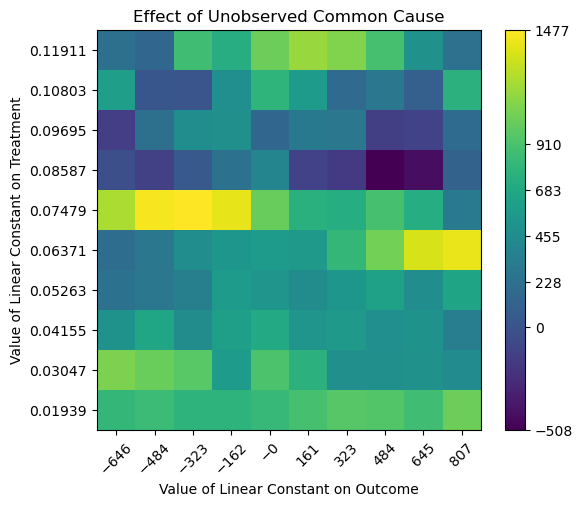

Refute: Add an Unobserved Common Cause
Estimated effect:910.1257834927283
New effect:(-507.7469688069241, 1476.5251698531138)



In [71]:
res_random_weight=model.refute_estimate(identified_estimand, estimate_weight, method_name="random_common_cause")
print(res_random_weight)

res_placebo=model.refute_estimate(identified_estimand, estimate_weight, method_name="placebo_treatment_refuter")
print(res_placebo)

res_subset=model.refute_estimate(identified_estimand, estimate_weight, method_name="data_subset_refuter")
print(res_subset)

res_add=model.refute_estimate(identified_estimand, estimate_weight, method_name="add_unobserved_common_cause")
print(res_add)

Refute: Add a random common cause
Estimated effect:910.1257834927283
New effect:910.125783492728
p value:1.0



/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/dowhy/causal_estimators/propensity_score_weighting_estimator.py:245: RuntimeWarning: invalid value encountered in double_scalars
  est = data["d_y"].sum() / sum_dy_weights - data["dbar_y"].sum() / sum_dbary_weights
/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/dowhy/causal_estimators/propensity_score_weighting_estimator.py:245: RuntimeWarning: invalid value encountered in double_scalars
  est = data["d_y"].sum() / sum_dy_weights - data["dbar_y"].sum() / sum_dbary_weights
/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/dowhy/causal_estimators/propensity_score_weighting_estimator.py:245: RuntimeWarning: invalid value encountered in double_scalars
  est = data["d_y"].sum() / sum_dy_weights - data["dbar_y"].sum() / sum_dbary_weights
/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/dowhy/causal_estimators/propensity_scor

Refute: Use a Placebo Treatment
Estimated effect:910.1257834927283
New effect:nan
p value:0.0

Refute: Use a subset of data
Estimated effect:910.1257834927283
New effect:921.5943788002035
p value:0.9199999999999999



/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


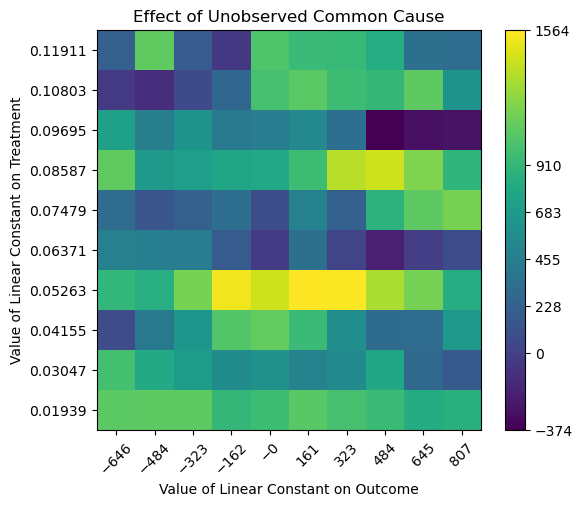

Refute: Add an Unobserved Common Cause
Estimated effect:910.1257834927283
New effect:(-373.5925451085868, 1563.9279529281548)



In [72]:
res_random_propensity=model.refute_estimate(identified_estimand, estimate_weight, method_name="random_common_cause")
print(res_random_propensity)

res_placebo=model.refute_estimate(identified_estimand, estimate_weight, method_name="placebo_treatment_refuter")
print(res_placebo)

res_subset=model.refute_estimate(identified_estimand, estimate_weight, method_name="data_subset_refuter")
print(res_subset)

res_add=model.refute_estimate(identified_estimand, estimate_weight, method_name="add_unobserved_common_cause")
print(res_add)



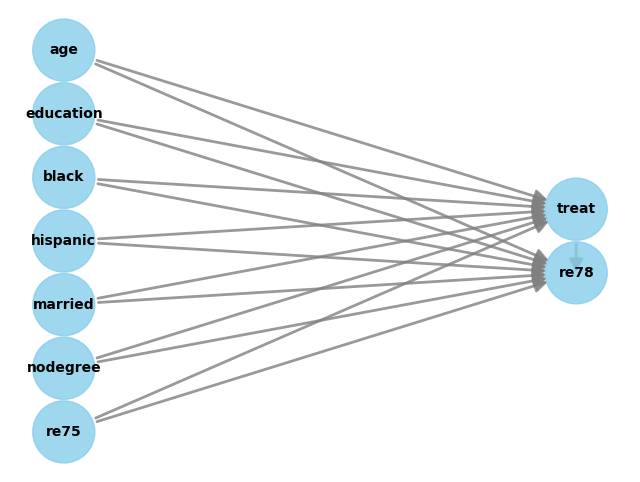

806.5112894563372
('age', 'treat')
805.5343989354069
-0.976890520930283
('age', 're78')
805.3869405545756
-1.1243489017615502
('education', 'treat')
798.5734995280563
-7.937789928280836
('education', 're78')
799.7636541943193
-6.747635262017866
('black', 'treat')
818.5735919712934
12.062302514956173
('black', 're78')
818.2186797984778
11.70739034214057
('hispanic', 'treat')
794.7647071640376
-11.746582292299536
('hispanic', 're78')
805.3246645155186
-1.1866249408185467
('married', 'treat')
798.2495549821633
-8.261734474173863
('married', 're78')
807.3364298132856
0.8251403569483955
('nodegree', 'treat')
806.7280567009284
0.21676724459121033
('nodegree', 're78')
830.6733853138066
24.162095857469467
('re75', 'treat')
793.3728607300791
-13.138428726258098
('re75', 're78')
793.6092285621689
-12.902060894168244
[-0.976890520930283, -1.1243489017615502, -7.937789928280836, -6.747635262017866, 12.062302514956173, 11.70739034214057, -11.746582292299536, -1.1866249408185467, -8.261734474173863,

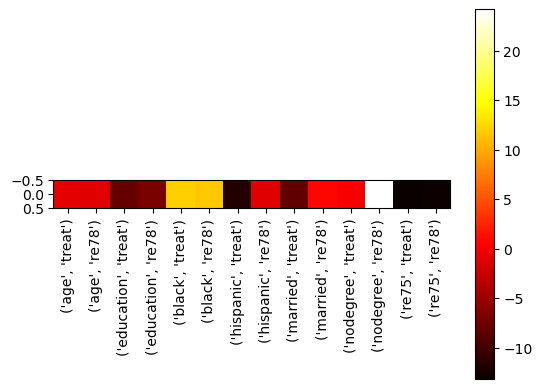

In [92]:
import matplotlib.pyplot as plt
# try dropping each of the edges in the graph and see if the estimate changes
edges = model._graph._graph.edges()

change = [0]*(len(edges)-1)
model.view_model()

print(estimate_linreg.value)

for i, edge in enumerate(list(edges)[:-1]):
    print(edge)
    old_graph = model._graph._graph.copy()
    new_graph = model._graph._graph.copy()
    new_graph.remove_edge(edge[0], edge[1])
    model._graph._graph = new_graph
    identified_estimand = model.identify_effect()
    # model.view_model()
    estim_linreg = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression").value
    # try:
    #     estim_matching = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_matching").value
    # except:
    #     estim_matching = np.nan
    # try:
    #     estim_strat = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_stratification").value
    # except:
    #     estim_strat = np.nan
    # try:
    #     estim_weight = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_weighting").value
    # except:
        # estim_weight = np.nan
    # change[i] = [estim_linreg, estim_matching, estim_strat, estim_weight]
    change[i] = estim_linreg-estimate_linreg.value
    print(estim_linreg)
    print(change[i])

    model._graph._graph = old_graph



print(change)
plt.imshow(np.array(change).reshape(1, -1), cmap='hot', interpolation='nearest')
# plt.x_ticks(range(len(edges)), labels=edges)
plt.xticks(range(len(edges)-1), labels=list(edges)[:-1], rotation=90)
plt.colorbar()
plt.show()





Original Causal Estimate (Linear Regression): 806.5112894563372
Inserting edge: ('re75', 'treat')
New estimate (Linear Regression): 806.5112894563372
Change in estimate: [0.0, 0.0, 0.0, 0.0]
Inserting edge: ('education', 're75')
New estimate (Linear Regression): 806.5112894563372
Change in estimate: [0.0, 0.0, 0.0, 0.0]
Inserting edge: ('education', 'treat')
New estimate (Linear Regression): 806.5112894563372
Change in estimate: [0.0, 0.0, 0.0, 0.0]
Inserting edge: ('married', 're75')
New estimate (Linear Regression): 806.5112894563372
Change in estimate: [0.0, 0.0, 0.0, 0.0]
Inserting edge: ('nodegree', 'treat')
New estimate (Linear Regression): 806.5112894563372
Change in estimate: [0.0, 0.0, 0.0, 0.0]
Changes in causal estimates: [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (5,) and arg 1 with shape (5, 4).

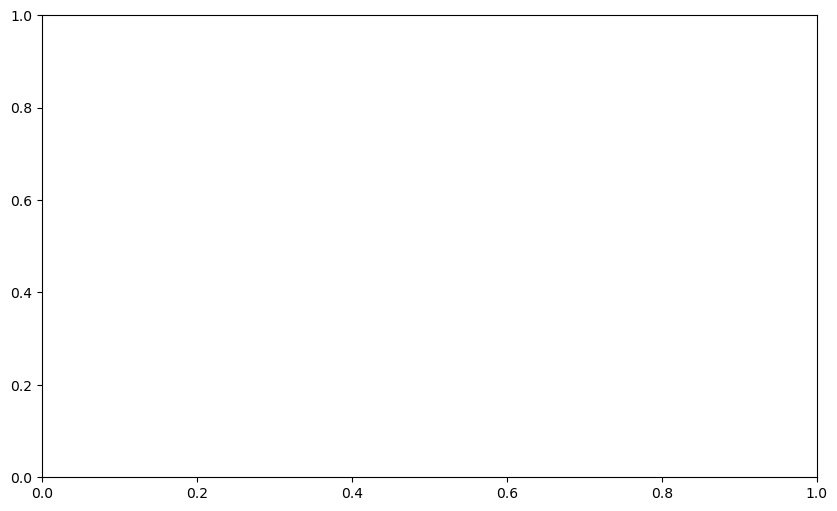

In [97]:
import matplotlib.pyplot as plt
import numpy as np

# Original causal effect value
print("Original Causal Estimate (Linear Regression):", estimate_linreg.value)

# Define the list of edges to add
edges_to_add = [
    ("re75", "treat"),     # Edge 1: Prior earnings -> Treatment
    ("education", "re75"), # Edge 2: Education -> Prior earnings
    ("education", "treat"),# Edge 3: Education -> Treatment
    ("married", "re75"),   # Edge 4: Married -> Prior earnings
    ("nodegree", "treat")  # Edge 5: No degree -> Treatment
]

# Initialize variables to track changes
change = []
new_edges = []

# Loop through each edge in the list and add it to the graph
for i, edge in enumerate(edges_to_add):
    print(f"Inserting edge: {edge}")
    old_graph = model._graph._graph.copy()
    new_graph = model._graph._graph.copy()
    
    new_graph.add_edge(edge[0], edge[1])
    model._graph._graph = new_graph
    
    # Identify the causal effect with the modified graph
    identified_estimand = model.identify_effect()
    # model.view_model() # Uncomment to view the updated graph
    
    try:
        estim_linreg = model.estimate_effect(
            identified_estimand, 
            method_name="backdoor.linear_regression"
        ).value
    except Exception as e:
        print(f"Error while estimating with edge {edge}: {e}")
        estim_linreg = np.nan
    try:
        estim_matching = model.estimate_effect(
            identified_estimand, 
            method_name="backdoor.propensity_score_matching"
        ).value
    except Exception as e:
        print(f"Error while estimating with edge {edge}: {e}")
        estim_matching = np.nan
    try:
        estim_strat = model.estimate_effect(
            identified_estimand, 
            method_name="backdoor.propensity_score_stratification"
        ).value
    except Exception as e:
        print(f"Error while estimating with edge {edge}: {e}")
        estim_strat = np.nan
    try:
        estim_weight = model.estimate_effect(
            identified_estimand, 
            method_name="backdoor.propensity_score_weighting"
        ).value
    except Exception as e:
        print(f"Error while estimating with edge {edge}: {e}")
        estim_weight = np.nan
    
    
    # Track the change in the causal estimate
    change.append([estim_linreg - estimate_linreg.value, estim_matching - estimate_matching.value, estim_strat - estimate_strat.value, estim_weight - estimate_weight.value])
    new_edges.append(edge)
    
    print(f"New estimate (Linear Regression): {estim_linreg}")
    print(f"Change in estimate: {change[-1]}")

    # Restore the original graph
    model._graph._graph = old_graph

# Visualize the changes
print("Changes in causal estimates:", change)
plt.figure(figsize=(10, 6))
plt.bar(range(len(new_edges)), change, color="skyblue")
plt.xticks(range(len(new_edges)), labels=[f"{e[0]}->{e[1]}" for e in new_edges], rotation=45)
plt.ylabel("Change in Estimate")
plt.title("Impact of Adding Edges on Causal Estimate")
plt.show()


In [75]:
# res_random_matching=model.refute_estimate(identifed_estimand_treat, estimate_matching, method_name="random_common_cause")
# print(res_random_matching)

# res_placebo=model.refute_estimate(identified_estimand_treat, estimate_matching, method_name="placebo_treatment_refuter")
# print(res_placebo)

# res_subset=model.refute_estimate(identified_estimand_treat, estimate_matching, method_name="data_subset_refuter")
# print(res_subset)

# res_add=model.refute_estimate(identified_estimand_treat, estimate_matching, method_name="add_unobserved_common_cause")
# print(res_add)

# res_random_strat=model.refute_estimate(identified_estimand_treat, estimate_strat, method_name="random_common_cause")
# print(res_random_strat)

# res_random_weight=model.refute_estimate(identified_estimand_treat, estimate_weight, method_name="random_common_cause")
# print(res_random_weight)

# res_placebo=model.refute_estimate(identified_estimand_treat, estimate_weight, method_name="placebo_treatment_refuter")
# print(res_placebo)

# res_subset=model.refute_estimate(identified_estimand_treat, estimate_weight, method_name="data_subset_refuter")
# print(res_subset)

# res_add=model.refute_estimate(identified_estimand_treat, estimate_weight, method_name="add_unobserved_common_cause")
# print(res_add)

# res_random_propensity=model.refute_estimate(identified_estimand_treat, estimate_weight, method_name="random_common_cause")
# print(res_random_propensity)

# res_placebo=model.refute_estimate(identified_estimand_treat, estimate_weight, method_name="placebo_treatment_refuter")
# print(res_placebo)

# res_subset=model.refute_estimate(identified_estimand_treat, estimate_weight, method_name="data_subset_refuter")
# print(res_subset)

# res_add=model.refute_estimate(identified_estimand_treat, estimate_weight, method_name="add_unobserved_common_cause")
# print(res_add)

res_random_linreg=model.refute_estimate(identified_estimand_treat, estimate_linreg, method_name="random_common_cause")
print(res_random_linreg)

res_placebo=model.refute_estimate(identified_estimand_treat, estimate_linreg, method_name="placebo_treatment_refuter")
print(res_placebo)

res_subset=model.refute_estimate(identified_estimand_treat, estimate_linreg, method_name="data_subset_refuter")
print(res_subset)

res_add=model.refute_estimate(identified_estimand_treat, estimate_linreg, method_name="add_unobserved_common_cause", 
print(res_add)

SyntaxError: positional argument follows keyword argument (1580073416.py, line 50)